# Multinomial NNGP Lengthscale LOOCV

Aitchison distance を指標に、lengthscale の候補を LOOCV で比較します。


※ `max_sites_per_period` を変更すれば、全遺跡 vs. サブセットのいずれでも実行できます。


In [1]:
import gc
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

from bayesian_statistics.models.preprocessing.data_preprocessor import (
    ObsidianDataPreprocessor,
)
from bayesian_statistics.nngp.model import (
    MultinomialDataset,
    MultinomialNNGPConfig,
    prepare_multinomial_dataset,
    run_mcmc,
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
gc.collect();

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data_dir = "/home/ohta/dev/bayesian_statistics/data"
variable_names = [
    "average_elevation",
    "average_slope_angle",
    "cost_kouzu",
    "cost_shinshu",
    "cost_hakone",
    "cost_takahara",
    "cost_river",
]
time_periods = {
    0: "早期・早々期",
    1: "前期",
    2: "中期",
    3: "後期",
    4: "晩期",
}
origins = ["神津島", "信州", "箱根", "高原山", "その他"]

lengthscale_grid = [0.05, 0.1, 0.15, 0.2]
max_sites_per_period = 10  # None にすると全遺跡で実行

n_iter = 200
burn_in = 50
thinning = 1
neighbor_count = 40
kernel_variance = 1.0
seed_base = 1234

preprocessor = ObsidianDataPreprocessor(data_dir, scale_variables=True)
preprocessor.load_data()
gc.collect();

In [3]:
datasets_by_period: dict[int, MultinomialDataset] = {}
for period in time_periods:
    dataset = prepare_multinomial_dataset(
        preprocessor=preprocessor,
        period=period,
        origins=origins,
        variable_names=variable_names,
        grid_subsample_ratio=0.01,
        drop_zero_total_sites=True,
    )
    datasets_by_period[period] = dataset
    print(
        f"period {period}: sites={dataset.num_sites()}, grid={dataset.grid_points.shape[0]}"
    )

gc.collect();

period 0: sites=53, grid=13575
period 1: sites=61, grid=13575
period 2: sites=146, grid=13575
period 3: sites=59, grid=13575
period 4: sites=18, grid=13575


In [4]:
def build_loocv_dataset(dataset_full: MultinomialDataset, drop_idx: int):
    keep_mask = np.ones(dataset_full.num_sites(), dtype=bool)
    keep_mask[drop_idx] = False

    coords = dataset_full.coords[keep_mask]
    counts = dataset_full.counts[keep_mask]
    totals = dataset_full.total_counts[keep_mask]
    design_sites = dataset_full.design_matrix_sites[keep_mask]
    site_ids = dataset_full.site_ids[keep_mask]

    left_coord = dataset_full.coords[drop_idx]
    left_design = dataset_full.design_matrix_sites[drop_idx]

    grid_points = np.vstack([dataset_full.grid_points, left_coord])
    design_grid = np.vstack([dataset_full.design_matrix_grid, left_design])

    dataset_train = MultinomialDataset(
        period=dataset_full.period,
        origins=dataset_full.origins,
        coords=coords,
        counts=counts,
        total_counts=totals,
        design_matrix_sites=design_sites,
        grid_points=grid_points,
        design_matrix_grid=design_grid,
        site_ids=site_ids,
        variable_names=dataset_full.variable_names,
    )

    target_grid_idx = grid_points.shape[0] - 1
    observed_counts = dataset_full.counts[drop_idx]
    observed_total = dataset_full.total_counts[drop_idx]
    observed_comp = observed_counts / observed_total

    return dataset_train, observed_comp, target_grid_idx


def aitchison_distance(p: np.ndarray, q: np.ndarray, eps: float = 1e-9) -> float:
    p_ = np.clip(p, eps, None)
    q_ = np.clip(q, eps, None)
    p_ = p_ / p_.sum()
    q_ = q_ / q_.sum()
    log_ratio = np.log(p_) - np.log(q_)
    log_ratio -= log_ratio.mean()
    return float(np.linalg.norm(log_ratio))


def iter_site_indices(dataset_full: MultinomialDataset, max_sites: Optional[int]):
    total = dataset_full.num_sites()
    if max_sites is None or max_sites >= total:
        return range(total)
    return range(max_sites)


gc.collect();

In [5]:
records: list[dict[str, float]] = []

for lengthscale in lengthscale_grid:
    print(f"Lengthscale {lengthscale}")
    for period, label in time_periods.items():
        dataset_full = datasets_by_period[period]
        limit = dataset_full.num_sites()
        if max_sites_per_period is not None:
            limit = min(limit, max_sites_per_period)
        if limit == 0:
            continue

        for drop_idx in tqdm(range(limit), leave=False, desc=f"period {period}"):
            dataset_train, observed_comp, target_idx = build_loocv_dataset(
                dataset_full, drop_idx
            )

            config = MultinomialNNGPConfig(
                n_iter=n_iter,
                burn_in=burn_in,
                thinning=thinning,
                neighbor_count=neighbor_count,
                kernel_lengthscale=lengthscale,
                kernel_variance=kernel_variance,
                seed=seed_base + period * 1000 + drop_idx,
            )

            results = run_mcmc(dataset_train, config)
            grid_probs = results.posterior_grid_mean(sample_conditional=False)
            pred_comp = grid_probs[:, target_idx]
            dist = aitchison_distance(pred_comp, observed_comp)

            records.append(
                {
                    "lengthscale": lengthscale,
                    "period": period,
                    "site_id": int(dataset_full.site_ids[drop_idx]),
                    "aitchison": dist,
                }
            )

            del results
            gc.collect()

results_df = pd.DataFrame(records)
display(results_df.head())

csv_path = Path("output/nngp_ratio_maps/loocv_results.csv")
csv_path.parent.mkdir(parents=True, exist_ok=True)
results_df.to_csv(csv_path, index=False)
print(f"Saved raw results to {csv_path}")

Lengthscale 0.05


period 0:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1732.22it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 51.15it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1735.11it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.23it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1820.20it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.49it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1743.60it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.92it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1726.05it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 55.14it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1804.27it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 52.87it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1734.79it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.64it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1736.30it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.49it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1731.11it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.78it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1856.73it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.74it/s]


period 1:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1741.77it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.97it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1873.53it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.30it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1729.80it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.72it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1725.02it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.44it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1727.69it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 45.48it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1715.23it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.09it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1719.30it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.40it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1750.90it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.66it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1747.56it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.74it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1730.42it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.95it/s]


period 2:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1743.82it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.18it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1743.69it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.17it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1753.47it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.84it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1762.90it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.40it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1877.68it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.03it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1717.07it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.02it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1730.73it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.12it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1777.69it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.44it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:06<00:00, 2122.14it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.48it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1735.01it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.15it/s]


period 3:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1728.28it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.53it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1710.33it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.01it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1763.48it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.57it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1745.22it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.40it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1734.29it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 50.42it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1747.89it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.61it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1790.80it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.59it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1827.18it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.56it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1739.47it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.94it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1750.60it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.69it/s]


period 4:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4060.93it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 146.83it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3970.59it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 155.51it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3868.08it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 146.94it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3802.16it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 146.55it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3968.17it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 156.08it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3792.68it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 149.58it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4028.09it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 154.57it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4038.47it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 160.25it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4022.58it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 156.70it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3841.78it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 157.15it/s]


Lengthscale 0.1


period 0:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1753.95it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.20it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1803.72it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 55.56it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1842.56it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 52.40it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1761.92it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.96it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1755.40it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 55.15it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1742.36it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.98it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1750.41it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 56.40it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1731.27it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.78it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1803.16it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 55.84it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1765.39it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.98it/s]


period 1:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1900.21it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.55it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1732.55it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.49it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1733.87it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.68it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1749.58it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.44it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1717.77it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 45.25it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1736.78it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.71it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1731.33it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.78it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1726.12it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.17it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1733.20it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.31it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1849.21it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.61it/s]


period 2:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1733.02it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.86it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1736.82it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.51it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1745.73it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.08it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1748.42it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.27it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1725.30it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.32it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1759.59it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.23it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1719.76it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.59it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1759.60it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.65it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1747.38it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.47it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1720.80it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.45it/s]


period 3:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1774.20it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.88it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1733.00it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.11it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1753.38it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.77it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1841.90it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.37it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1856.60it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 50.28it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1730.44it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.98it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1747.39it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.47it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1743.79it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.86it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1847.84it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.29it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1744.10it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.16it/s]


period 4:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4115.48it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 156.66it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4120.51it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 161.52it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4116.30it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 154.04it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4100.44it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 157.57it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4103.71it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 153.71it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4116.38it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 154.18it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4069.76it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 150.39it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4078.36it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 157.24it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3722.84it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 149.92it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3826.20it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 157.51it/s]


Lengthscale 0.15


period 0:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1748.95it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.17it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1790.84it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.90it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1739.70it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.47it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1735.25it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 50.12it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:06<00:00, 2242.36it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.54it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1757.64it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.81it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1792.80it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 55.60it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1737.74it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 55.59it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1746.01it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.25it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1763.62it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 55.73it/s]


period 1:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1731.89it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.51it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1770.89it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 45.94it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1760.84it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.25it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1746.92it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.62it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1735.65it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.81it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1740.19it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.07it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1738.89it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.02it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1752.56it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.56it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1735.06it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.65it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1750.56it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.41it/s]


period 2:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1740.00it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.50it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1747.55it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.31it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1759.38it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.55it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1771.38it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.23it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1732.35it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.35it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1772.16it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.26it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1716.37it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 20.94it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1717.90it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.73it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1727.96it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.51it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1791.82it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.16it/s]


period 3:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1708.35it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.01it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1748.96it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 50.33it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1735.72it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.86it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1738.03it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.32it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1732.81it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.20it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1735.09it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.00it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1735.18it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.64it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1744.02it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.73it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1742.80it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.96it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1824.42it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.77it/s]


period 4:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4088.71it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 158.61it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4061.89it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 156.69it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4101.78it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 149.69it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4131.36it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 154.87it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4136.89it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 150.92it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4107.42it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 161.00it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3804.15it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 156.74it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3889.44it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 152.25it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4125.55it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 162.81it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4011.50it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 154.27it/s]


Lengthscale 0.2


period 0:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1742.90it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.90it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1762.20it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.82it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1746.10it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.24it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1727.26it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.27it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:06<00:00, 2110.06it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 56.15it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1756.56it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.57it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1724.19it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 52.45it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1740.44it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 56.15it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1738.40it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 53.23it/s]


1. building NNGP factor cache for 52 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1730.10it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 54.88it/s]


period 1:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1764.06it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.32it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1767.28it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.84it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1735.85it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.75it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1808.44it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.87it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1765.06it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.58it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1718.82it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.57it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1728.04it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.16it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1752.84it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.93it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1744.53it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.91it/s]


1. building NNGP factor cache for 60 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1746.96it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.83it/s]


period 2:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1722.16it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.57it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1705.41it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.79it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1729.65it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.67it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1727.12it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.67it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1727.67it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.50it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1733.22it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 20.76it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1787.33it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.80it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1735.58it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.34it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1861.67it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 21.38it/s]


1. building NNGP factor cache for 145 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1820.22it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:09<00:00, 20.77it/s]


period 3:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:05<00:00, 2268.12it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 50.12it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1737.96it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 48.28it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1725.92it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.86it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1729.07it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.36it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1739.89it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.63it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1737.52it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.39it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1749.06it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:03<00:00, 51.11it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1727.06it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 46.93it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1836.83it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 47.70it/s]


1. building NNGP factor cache for 58 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:07<00:00, 1759.77it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:04<00:00, 49.22it/s]


period 4:   0%|          | 0/10 [00:00<?, ?it/s]

1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4083.89it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 156.22it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4053.90it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 150.21it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4098.57it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 161.84it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4080.64it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 149.08it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4101.83it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 144.03it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4097.05it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 156.41it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4096.21it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 151.00it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4190.25it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 151.23it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 4094.63it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 157.18it/s]


1. building NNGP factor cache for 17 sites...
2. using 40 neighbors for NNGP approximation...


100%|██████████| 13576/13576 [00:03<00:00, 3788.36it/s]


3. running MCMC...
4. saving 150 posterior samples...


100%|██████████| 200/200 [00:01<00:00, 147.28it/s]


,lengthscale,period,site_id,aitchison
0,0.05,0,19,19.921073
1,0.05,0,31,20.832645
2,0.05,0,34,21.740469
3,0.05,0,39,17.699751
4,0.05,0,61,18.789059


Saved raw results to output/nngp_ratio_maps/loocv_results.csv


In [6]:
summary = (
    results_df.groupby("lengthscale")["aitchison"]
    .agg(["mean", "std", "count"])
    .sort_values("mean")
)
display(summary)
best_lengthscale = summary.index[0]
print(f"Best lengthscale (mean Aitchison): {best_lengthscale}")

summary_path = Path("output/nngp_ratio_maps/loocv_summary.csv")
summary.to_csv(summary_path)
print(f"Saved summary to {summary_path}")

,mean,std,count
lengthscale,,,
0.20,18.310424,1.787763,50
0.15,18.436778,1.864446,50
0.10,18.613555,1.885698,50
0.05,18.983438,1.793162,50


Best lengthscale (mean Aitchison): 0.2
Saved summary to output/nngp_ratio_maps/loocv_summary.csv


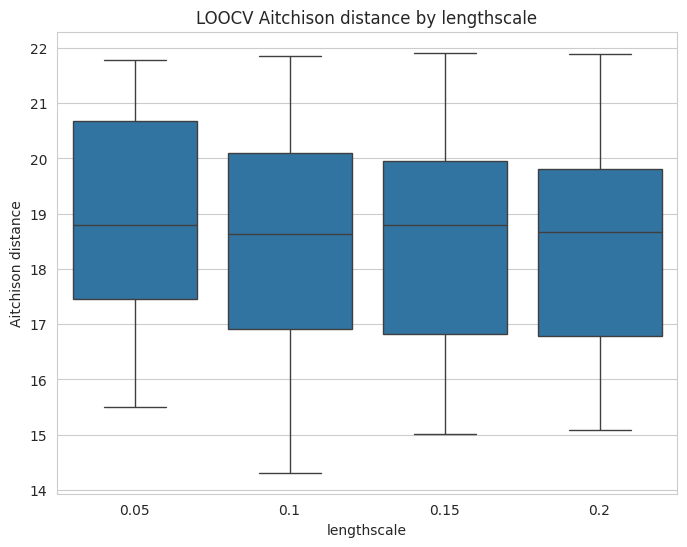

Saved boxplot to output/nngp_ratio_maps/loocv_lengthscale_boxplot.png


In [7]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df, x="lengthscale", y="aitchison")
plt.title("LOOCV Aitchison distance by lengthscale")
plt.xlabel("lengthscale")
plt.ylabel("Aitchison distance")
plot_path = Path("output/nngp_ratio_maps/loocv_lengthscale_boxplot.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved boxplot to {plot_path}")

上記の表・グラフを参考に、lengthscale のチューニングを行ってください。
